In [2]:
!pip install yake

In [83]:
import torch

# Check if MPS (Metal Performance Shaders) is available
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS (GPU) is available and will be used.")
else:
    device = torch.device("cpu")
    print("MPS (GPU) is not available. CPU will be used.")

MPS (GPU) is available and will be used.


In [84]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline
import yake
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import re
import stanza
import torch
import string

In [85]:
# Path to the CSV file
csv_path = './translated_file_helsinki.csv'

# Load the CSV into a pandas DataFrame
try:
    df = pd.read_csv(csv_path)
    print("CSV file loaded successfully.")
    print("Columns in the CSV:", df.columns.tolist())
    display(df.head())
except FileNotFoundError:
    raise FileNotFoundError(f"The file at path '{csv_path}' was not found. Please verify the path and try again.")
except Exception as e:
    raise Exception(f"An error occurred while loading the CSV file: {e}")

CSV file loaded successfully.
Columns in the CSV: ['source', 'article_url', 'title', 'date', 'shortened_full_text', 'combined_text', 'sentiment_label', 'sentiment_score', 'title_tr', 'shortened_full_text_tr']


,source,article_url,title,date,shortened_full_text,combined_text,sentiment_label,sentiment_score,title_tr,shortened_full_text_tr
0,BBC,https://www.bbc.com/sport/football/65930883,Roberts aims to emulate Kompany as coach in fu...,24 Jun 2023,"Roberts, who is in Wales' squad for Monday's E...",Roberts aims to emulate Kompany as coach in fu...,POSITIVE,0.998434,"Roberts, Kompany'yi gelecekte antrenör olarak ...",Pazartesi günü Türkiye'de Euro 2024 eleme maçı...
1,Aljazeera,https://www.aljazeera.com/where/turkey/news/20...,World leaders congratulate Turkey’s Erdogan on...,02:40,All eyes were on NATO member Turkey ahead of i...,World leaders congratulate Turkey’s Erdogan on...,POSITIVE,0.997460,Dünya liderleri Erdoğan'ı seçim zaferinden dol...,Tüm gözler NATO üyesi Türkiye'yi Erdoğan'ın ik...
2,The Guardian,https://www.theguardian.com/commentisfree/2024...,The Guardian view on endangered languages: spo...,5 Apr 2024 19.25 CEST…… comments,"Romeyka, which is spoken by an ageing populati...",The Guardian view on endangered languages: spo...,POSITIVE,0.979718,Tehlikedeki diller hakkında Guardian görüşü: b...,Türkiye'nin Karadeniz kıyısındaki dağ köylerin...
3,Aljazeera,https://www.aljazeera.com/where/turkey/news/20...,Turkey election: Your guide to how the elector...,12 May 2023,There are more than 64 million eligible voters...,Turkey election: Your guide to how the elector...,POSITIVE,0.961055,Türkiye seçimi: Seçim sisteminin nasıl çalıştı...,Türkiye'de ilk kez beş milyona yakın seçmen ol...
4,Aljazeera,https://www.aljazeera.com/where/turkey/news/20...,"Turkey to hold presidential, parliamentary ele...",10 Mar 2023,Elections are expected to be the Turkish oppos...,"Turkey to hold presidential, parliamentary ele...",NEGATIVE,0.557481,"Türkiye 14 Mayıs'ta cumhurbaşkanlığı, parlamen...",Seçimlerin Türkiye muhalefetinin 20 yıl içinde...


In [86]:
# Verify the existence of required columns
required_columns = ['title_tr', 'shortened_full_text_tr']
missing_columns = [col for col in required_columns if col not in df.columns]
if missing_columns:
    raise ValueError(f"Required columns {missing_columns} are missing from the CSV file.")

# Merge the columns
df['title_and_text'] = df['title_tr'].astype(str) + ". " + df['shortened_full_text_tr'].astype(str)

# Display the merged column
display(df[['title_tr', 'shortened_full_text_tr', 'title_and_text']].head())

,title_tr,shortened_full_text_tr,title_and_text
0,"Roberts, Kompany'yi gelecekte antrenör olarak ...",Pazartesi günü Türkiye'de Euro 2024 eleme maçı...,"Roberts, Kompany'yi gelecekte antrenör olarak ..."
1,Dünya liderleri Erdoğan'ı seçim zaferinden dol...,Tüm gözler NATO üyesi Türkiye'yi Erdoğan'ın ik...,Dünya liderleri Erdoğan'ı seçim zaferinden dol...
2,Tehlikedeki diller hakkında Guardian görüşü: b...,Türkiye'nin Karadeniz kıyısındaki dağ köylerin...,Tehlikedeki diller hakkında Guardian görüşü: b...
3,Türkiye seçimi: Seçim sisteminin nasıl çalıştı...,Türkiye'de ilk kez beş milyona yakın seçmen ol...,Türkiye seçimi: Seçim sisteminin nasıl çalıştı...
4,"Türkiye 14 Mayıs'ta cumhurbaşkanlığı, parlamen...",Seçimlerin Türkiye muhalefetinin 20 yıl içinde...,"Türkiye 14 Mayıs'ta cumhurbaşkanlığı, parlamen..."


In [87]:
def normalize_punctuation(text):
    """
    Normalizes punctuation in the text by removing extra spaces and redundant marks.
    
    Parameters:
        text (str): The text to normalize.
    
    Returns:
        str: Normalized text.
    """
    # Remove extra spaces before punctuation
    text = re.sub(r'\s+([.,!?])', r'\1', text)
    # Replace multiple punctuation marks with a single one
    text = re.sub(r'([.,!?]){2,}', r'\1', text)
    return text

# Apply normalization
df['normalized_text'] = df['title_and_text'].apply(normalize_punctuation)

# Display the normalized text
display(df[['title_and_text', 'normalized_text']].head())

,title_and_text,normalized_text
0,"Roberts, Kompany'yi gelecekte antrenör olarak ...","Roberts, Kompany'yi gelecekte antrenör olarak ..."
1,Dünya liderleri Erdoğan'ı seçim zaferinden dol...,Dünya liderleri Erdoğan'ı seçim zaferinden dol...
2,Tehlikedeki diller hakkında Guardian görüşü: b...,Tehlikedeki diller hakkında Guardian görüşü: b...
3,Türkiye seçimi: Seçim sisteminin nasıl çalıştı...,Türkiye seçimi: Seçim sisteminin nasıl çalıştı...
4,"Türkiye 14 Mayıs'ta cumhurbaşkanlığı, parlamen...","Türkiye 14 Mayıs'ta cumhurbaşkanlığı, parlamen..."


In [88]:
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline

# Specify the NER model name
ner_model_name = "akdeniz27/bert-base-turkish-cased-ner"

# Load the tokenizer and model
try:
    tokenizer = AutoTokenizer.from_pretrained(ner_model_name)
    model = AutoModelForTokenClassification.from_pretrained(ner_model_name)
    print(f"Model and tokenizer '{ner_model_name}' loaded successfully.")
except Exception as e:
    raise Exception(f"An error occurred while loading the NER model '{ner_model_name}': {e}")

# Initialize the NER pipeline with GPU (MPS) support if available
try:
    ner_pipeline = pipeline(
        "ner",
        model=model,
        tokenizer=tokenizer,
        aggregation_strategy="simple",  # Aggregates tokens into entities
        device=0 if device.type == 'mps' else -1  # 0 for GPU (MPS), -1 for CPU
    )
    print("NER pipeline initialized successfully.")
except Exception as e:
    raise Exception(f"An error occurred while initializing the NER pipeline: {e}")

Model and tokenizer 'akdeniz27/bert-base-turkish-cased-ner' loaded successfully.
NER pipeline initialized successfully.


In [89]:
# Retrieve and print the model's label mapping
label_mapping = model.config.id2label
print("Model Label Mapping:")
print(label_mapping)

Model Label Mapping:
{0: 'O', 1: 'B-PER', 2: 'I-PER', 3: 'B-ORG', 4: 'I-ORG', 5: 'B-LOC', 6: 'I-LOC'}


In [90]:
def split_text(text, max_length=512):
    """
    Splits the input text into chunks not exceeding the specified maximum length.
    
    Parameters:
        text (str): The text to be split.
        max_length (int): The maximum number of characters per chunk.
    
    Returns:
        list: A list of text chunks.
    """
    return [text[i:i+max_length] for i in range(0, len(text), max_length)]

In [91]:
def extract_entities(text, pipeline, max_length=512):
    """
    Extracts named entities from the input text using the specified NER pipeline.
    
    Parameters:
        text (str): The text from which to extract entities.
        pipeline: The Hugging Face NER pipeline.
        max_length (int): The maximum number of characters per text chunk.
    
    Returns:
        list: A list of tuples containing entity text and its label.
    """
    chunks = split_text(text, max_length)
    entities = []
    for chunk in chunks:
        try:
            ner_results = pipeline(chunk)
            for ent in ner_results:
                entities.append((ent['word'], ent['entity_group']))
        except Exception as e:
            print(f"Error processing chunk: {e}")
    return entities

In [92]:
print("Starting entity extraction with the new NER model...")

# Apply the entity extraction function to each row's lemmatized text
df['entities'] = df['normalized_text'].apply(lambda x: extract_entities(x, ner_pipeline))

print("Entity extraction completed successfully.")
display(df[['normalized_text', 'entities']].head())

Starting entity extraction with the new NER model...
Entity extraction completed successfully.


,normalized_text,entities
0,"Roberts, Kompany'yi gelecekte antrenör olarak ...","[(Robert, PER), (##s, PER), (Komp, PER), (##an..."
1,Dünya liderleri Erdoğan'ı seçim zaferinden dol...,"[(Erdoğan, PER), (NATO, ORG), (Türkiye, LOC), ..."
2,Tehlikedeki diller hakkında Guardian görüşü: b...,"[(Guar, ORG), (##dian, ORG), (Türkiye, LOC), (..."
3,Türkiye seçimi: Seçim sisteminin nasıl çalıştı...,"[(Türkiye, LOC), (Türkiye, LOC), (Türkiye, LOC..."
4,"Türkiye 14 Mayıs'ta cumhurbaşkanlığı, parlamen...","[(Türkiye, LOC), (Türkiye, LOC), (Recep Tayyip..."


In [93]:
# Initialize YAKE keyword extractor for Turkish
kw_extractor = yake.KeywordExtractor(lan="tr", n=2, dedupLim=0.9, top=20, features=None)

In [94]:
def extract_keywords(text, extractor, max_length=512):
    """
    Extracts keywords from the input text using YAKE.
    
    Parameters:
        text (str): The text from which to extract keywords.
        extractor: The YAKE keyword extractor instance.
        max_length (int): The maximum number of characters per text chunk.
    
    Returns:
        list: A list of extracted keywords.
    """
    chunks = split_text(text, max_length)
    keywords = []
    for chunk in chunks:
        try:
            kw = extractor.extract_keywords(chunk)
            keywords.extend([keyword for keyword, score in kw])
        except Exception as e:
            print(f"Error extracting keywords from chunk: {e}")
    return keywords

In [95]:
# Initialize YAKE keyword extractor for Turkish
kw_extractor = yake.KeywordExtractor(lan="tr", n=2, dedupLim=0.9, top=20, features=None)

In [96]:
def extract_keywords(text, extractor, max_length=512):
    """
    Extracts keywords from the input text using YAKE.
    
    Parameters:
        text (str): The text from which to extract keywords.
        extractor: The YAKE keyword extractor instance.
        max_length (int): The maximum number of characters per text chunk.
    
    Returns:
        list: A list of extracted keywords.
    """
    chunks = split_text(text, max_length)
    keywords = []
    for chunk in chunks:
        try:
            kw = extractor.extract_keywords(chunk)
            keywords.extend([keyword for keyword, score in kw])
        except Exception as e:
            print(f"Error extracting keywords from chunk: {e}")
    return keywords

In [97]:
print("Starting keyword extraction...")

# Apply the keyword extraction function to each row's lemmatized text
df['keywords'] = df['normalized_text'].apply(lambda x: extract_keywords(x, kw_extractor))

print("Keyword extraction completed successfully.")
display(df[['normalized_text', 'keywords']].head())

Starting keyword extraction...
Keyword extraction completed successfully.


,normalized_text,keywords
0,"Roberts, Kompany'yi gelecekte antrenör olarak ...","[Kompany'yi gelecekte, etmeyi hedefliyor, gele..."
1,Dünya liderleri Erdoğan'ı seçim zaferinden dol...,"[Cumhurbaşkanı Erdoğan'ın, Erdoğan'ı seçim, li..."
2,Tehlikedeki diller hakkında Guardian görüşü: b...,"[Guardian görüşü, hakkında Guardian, Tehlikede..."
3,Türkiye seçimi: Seçim sisteminin nasıl çalıştı...,"[Seçim sisteminin, dair rehberiniz, çalıştığın..."
4,"Türkiye 14 Mayıs'ta cumhurbaşkanlığı, parlamen...","[Cumhurbaşkanı Recep, Recep Tayyip, Mayıs'ta T..."


In [98]:
# Flatten the list of all entities
all_entities = [ent for sublist in df['entities'] for ent in sublist]

# Separate entity texts and labels
entity_texts = [ent[0] for ent in all_entities]
entity_labels = [ent[1] for ent in all_entities]

# Count frequency of each entity label
label_counts = Counter(entity_labels)
print("Entity Label Counts:")
print(label_counts)

# Count frequency of each entity text
text_counts = Counter(entity_texts)
print("\nTop 30 Most Common Entities:")
print(text_counts.most_common(30))

Entity Label Counts:
Counter({'LOC': 19656, 'PER': 2875, 'ORG': 2597})

Top 30 Most Common Entities:
[('Türkiye', 8027), ('Suriye', 3232), ('Suudi Arabistan', 984), ('Erdoğan', 784), ('Rusya', 716), ('Kıbrıs', 654), ('AB', 392), ('İstanbul', 383), ('İsrail', 369), ('Ankara', 346), ('ABD', 336), ('NATO', 329), ('Filistin', 320), ('PKK', 291), ('Yunanistan', 288), ('AKP', 252), ('Osmanlı', 227), ('Recep Tayyip Erdoğan', 226), ('Gazze', 219), ('Anayasa Mahkemesi', 190), ('Ukrayna', 185), ('İngiltere', 181), ('Güneydoğu', 162), ('Arabistan', 161), ('Başbakanlık', 145), ('İsveç', 119), ('Ürdün', 110), ('Mısır', 99), ('Batı', 73), ('BM', 48)]


/var/folders/j2/69bjqs2x3m1g1ptxhl19z8mm0000gn/T/ipykernel_46585/843535666.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(label_counts.keys()), y=list(label_counts.values()), palette='viridis')


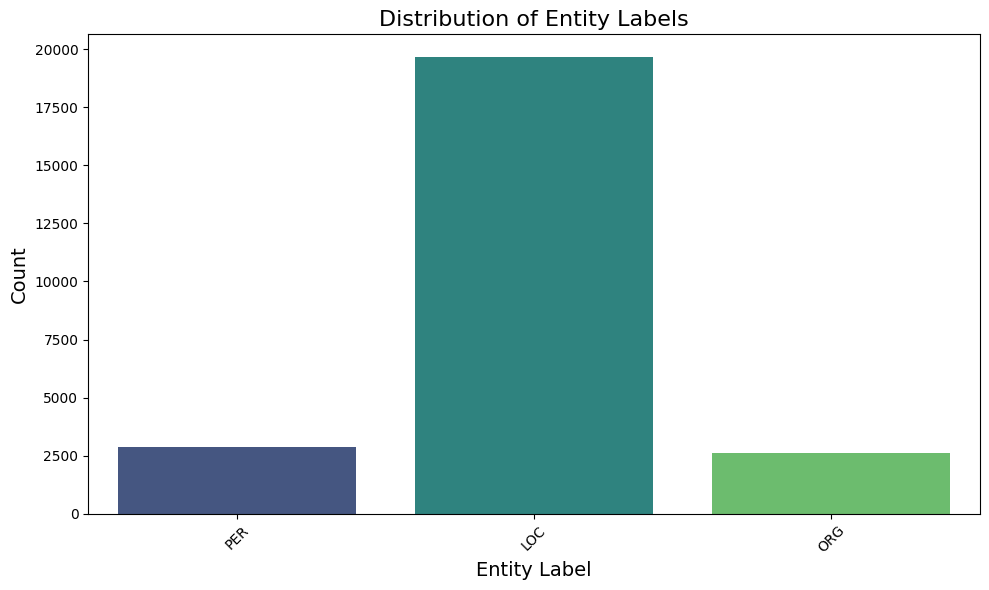

In [99]:
# Bar Plot for Entity Labels
plt.figure(figsize=(10,6))
sns.barplot(x=list(label_counts.keys()), y=list(label_counts.values()), palette='viridis')
plt.title('Distribution of Entity Labels', fontsize=16)
plt.xlabel('Entity Label', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('./entity_label_distribution.png')
plt.show()

/var/folders/j2/69bjqs2x3m1g1ptxhl19z8mm0000gn/T/ipykernel_46585/843535666.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(label_counts.keys()), y=list(label_counts.values()), palette='viridis')


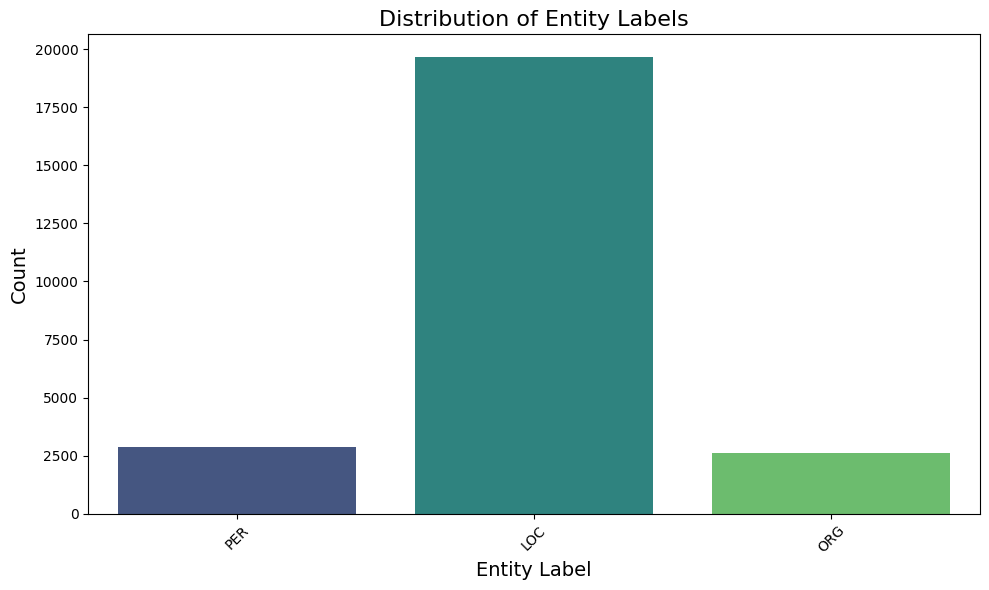

In [100]:
# Bar Plot for Entity Labels
plt.figure(figsize=(10,6))
sns.barplot(x=list(label_counts.keys()), y=list(label_counts.values()), palette='viridis')
plt.title('Distribution of Entity Labels', fontsize=16)
plt.xlabel('Entity Label', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('./entity_label_distribution.png')
plt.show()

/var/folders/j2/69bjqs2x3m1g1ptxhl19z8mm0000gn/T/ipykernel_46585/1977891765.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(entities), y=list(counts), palette='viridis')


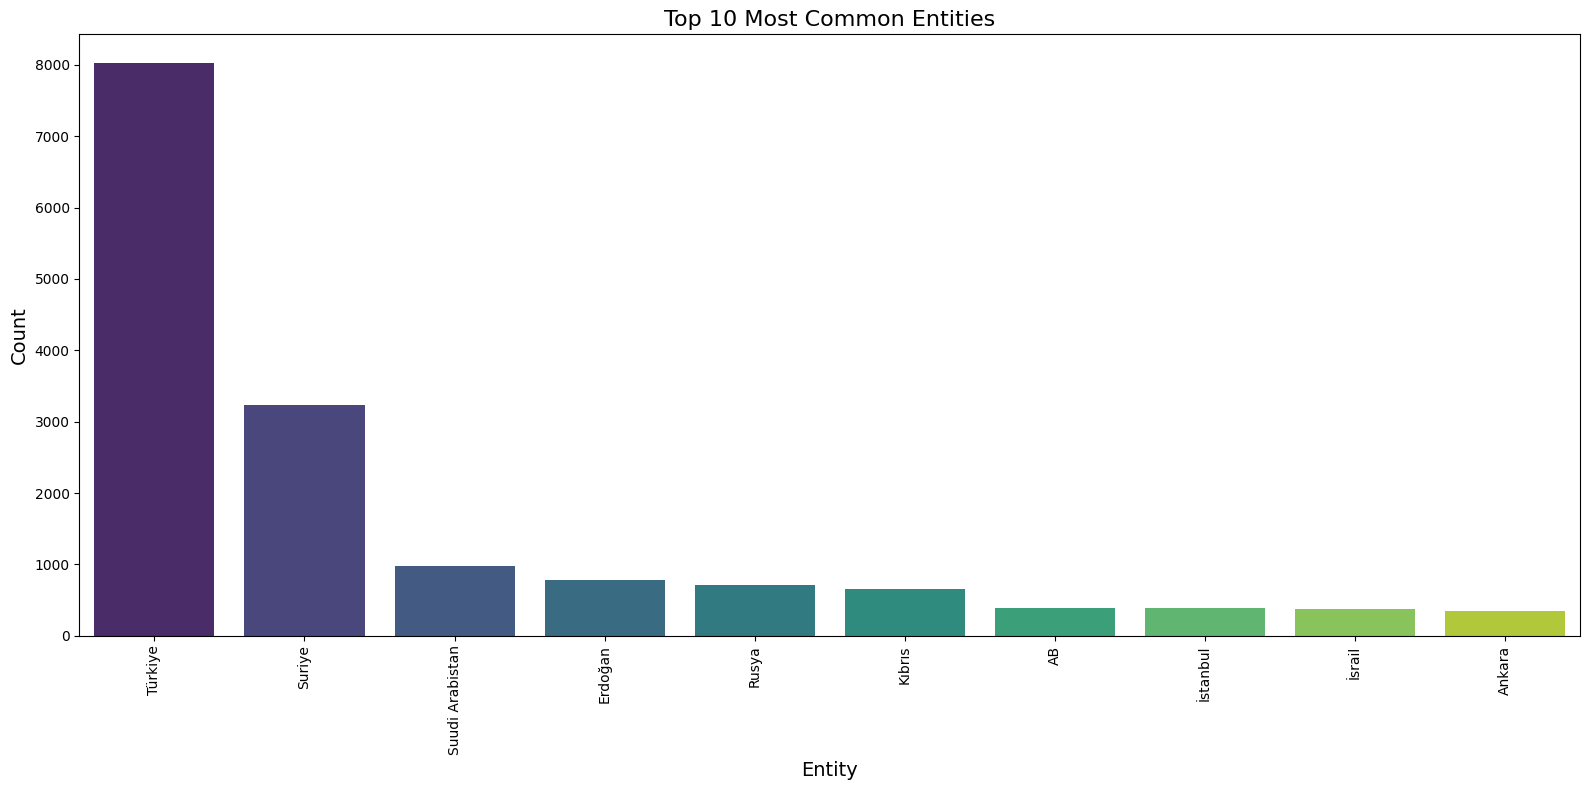

In [101]:
# Bar Plot for Top 10 Most Common Entities
top_entities = text_counts.most_common(10)
entities, counts = zip(*top_entities)

plt.figure(figsize=(16,8))
sns.barplot(x=list(entities), y=list(counts), palette='viridis')
plt.title('Top 10 Most Common Entities', fontsize=16)
plt.xlabel('Entity', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('./top_10_entities.png')
plt.show()

In [102]:
# Flatten the list of all keywords
all_keywords = [kw for sublist in df['keywords'] for kw in sublist]

# Count frequency of each keyword
keyword_counts = Counter(all_keywords)
print("\nTop 30 Most Common Keywords:")
print(keyword_counts.most_common(30))


Top 30 Most Common Keywords:
[("Türkiye'nin", 494), ('Türkiye', 398), ('Recep Tayyip', 204), ('Türk', 200), ('Cumhurbaşkanı Recep', 130), ('Tayyip Erdoğan', 127), ("Türkiye'de", 124), ('söyledi', 109), ('Erdoğan', 100), ("Erdoğan'ın", 92), ("Suriye'nin", 81), ('Türkiye Cumhurbaşkanı', 73), ("Türkiye'deki", 71), ('Suudi', 69), ("Suriye'deki", 68), ('karşı', 67), ("Tayyip Erdoğan'ın", 62), ('sonra', 59), ("Suriye'ye", 59), ('Suriye', 54), ("Suudi Arabistan'ın", 53), ("Türkiye'yi", 51), ("Arabistan'ın", 49), ('video', 48), ("Türkiye'ye", 47), ('büyük', 46), ('İstanbul', 46), ('belediye', 44), ('NATO', 40), ('Cumhurbaşkanı', 39)]


/var/folders/j2/69bjqs2x3m1g1ptxhl19z8mm0000gn/T/ipykernel_46585/2263366664.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(keywords), y=list(counts), palette='viridis')


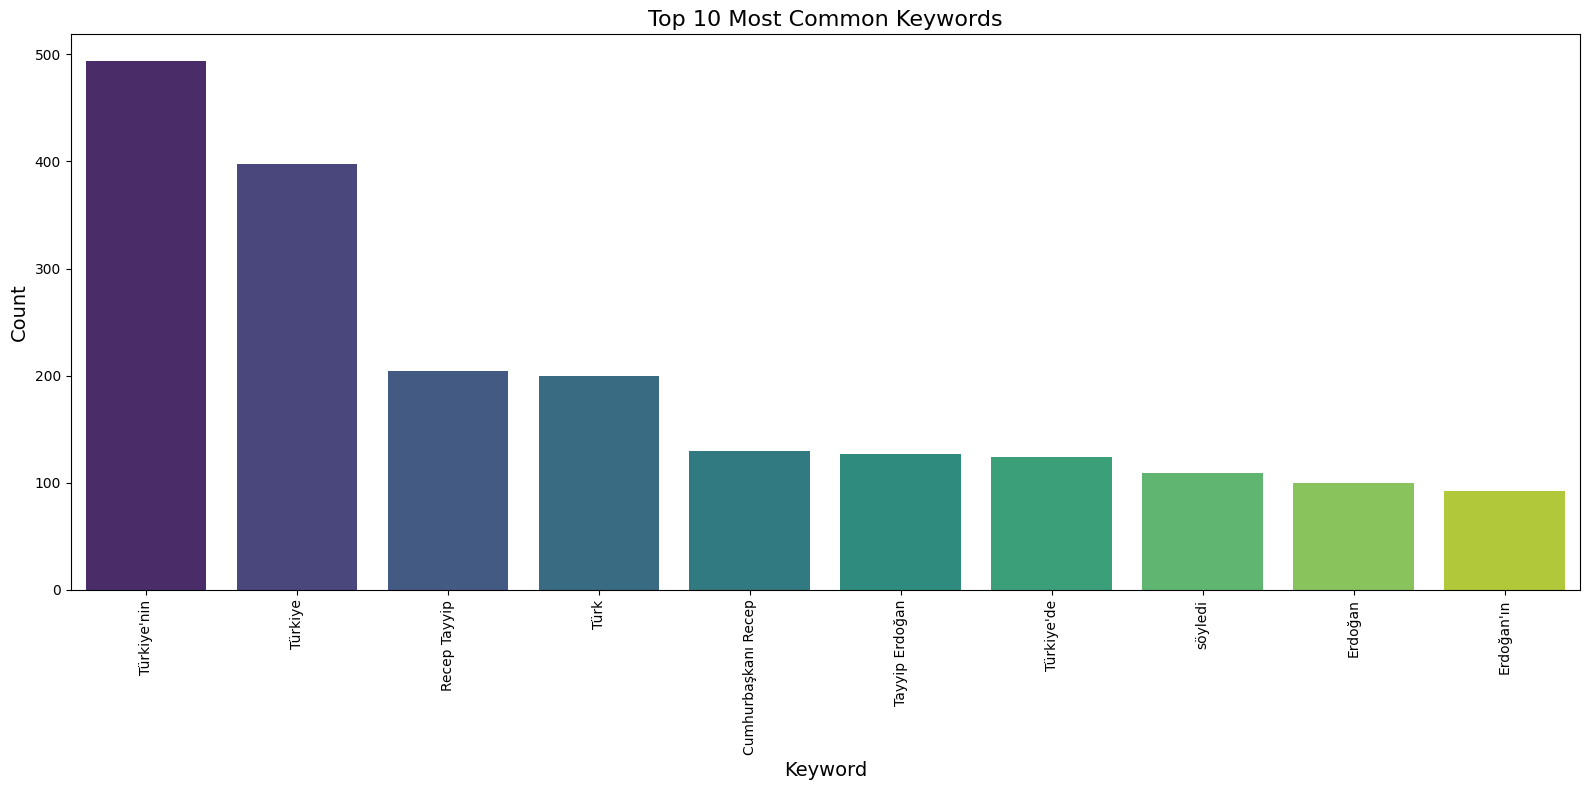

In [103]:
# Bar Plot for Top 10 Keywords
top_keywords = keyword_counts.most_common(10)
keywords, counts = zip(*top_keywords)

plt.figure(figsize=(16,8))
sns.barplot(x=list(keywords), y=list(counts), palette='viridis')
plt.title('Top 10 Most Common Keywords', fontsize=16)
plt.xlabel('Keyword', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('./top_10_keywords.png')
plt.show()

In [104]:
# Path to save the processed DataFrame
output_path = './processed_news_turkish_entities_keywords.csv'

# Save the DataFrame
try:
    df.to_csv(output_path, index=False)
    print(f"Processed data successfully saved to '{output_path}'.")
except Exception as e:
    raise Exception(f"An error occurred while saving the processed data: {e}")

Processed data successfully saved to './processed_news_turkish_entities_keywords.csv'.
